Tooling and helpers

In [2]:
import os
import csv
import torch

# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

def save_avg_loss(avg_loss, avg_eval_loss, epoch, test_name, csv_file_path="training_loss_log.csv"):
    # Define the header
    header = ['epoch', 'test_name', 'avg_train_loss', 'avg_eval_loss']

    # Check if the CSV file exists
    file_exists = os.path.isfile(csv_file_path)

    # Open the CSV file in append mode
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        # Write the header if the file does not exist
        if not file_exists:
            writer.writerow(header)
        # Write the epoch, timestamp, and average loss
        writer.writerow([epoch + 1, test_name, avg_loss, avg_eval_loss])

Device: cuda


cleaning memory

In [2]:
import torch
import gc

def clear_gpu_memory():
    # Empty CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()

    # Reset PyTorch's memory allocator
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.reset_accumulated_memory_stats()

    # Print current memory usage
    if torch.cuda.is_available():
        print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")

# Call the function after training
clear_gpu_memory()

GPU Memory allocated: 0.00 MB
GPU Memory cached: 0.00 MB


Eval fn

In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.sigmoid(outputs.logits) > threshold

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_batches = len(dataloader)
            if i % int(total_batches / 10) == 0:
                progress = (i / total_batches) * 100
                print(f"Eval: {i}/{total_batches} ({progress:.2f}%)")

    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average='micro')
    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')

    return avg_loss, f1, precision, recall

Test using cie 10 codes only

In [ ]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import re
from datetime import datetime

epochs = 60
model_name = "plncmm/bert-clinical-scratch-wl-es"
#model_name = "dccuchile/bert-base-spanish-wwm-uncased"
#model_name = "bert-base-uncased"
learning_rate = 1e-5 # 2e-5 is the default learning rate for AdamW
max_length = 128
train_batch_size = 8
eval_batch_size = 128
weight_decay = 0.001
#weight_decay = 0.01
patience = 8 # Number of epochs to wait for improvement, break if no improvement is seen
train_name = "regular"
test_name = f"{train_name}-{model_name.split("/")[0]}-{learning_rate}-{weight_decay}-{max_length}-{train_batch_size}-{eval_batch_size}-{datetime.now().timestamp()}"
print(f"Test name: {test_name}")

# Define the seed
#seed = 42
# Set the seed
#np.random.seed(seed)
#torch.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

class ICD10Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = [clean_text(text) for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


# Data loading and preprocessing cie10 codes
df = pd.read_csv('../csv_import_scripts/cie10-es-diagnoses.csv')
texts = df['description'].tolist()

#Just the first letters of the code
icd10_codes = df['code'].apply(lambda x: [x.strip().upper().split(".")[0]]).tolist()
#icd10_codes = df['code'].apply(lambda x: [x.strip().upper()]).tolist()
print(f"Number of codes: {len(icd10_codes)}")
print(icd10_codes[:10])
# One-hot encoding
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(icd10_codes)

# Tokenizer initialization
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
dataset = ICD10Dataset(texts, labels, tokenizer, max_length=max_length)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)

# Model initialization
model = BertForSequenceClassification.from_pretrained(model_name,
                                                     num_labels=len(mlb.classes_),
                                                     problem_type="multi_label_classification")
model.to(device)

#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Early stopping setup
best_eval_loss = float('inf')
no_improve = 0

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_batches = len(train_dataloader)
        current_batch = i + 1
        if i % int(total_batches/10) == 0:
            progress = (current_batch / total_batches) * 100
            print(f"Epoch {epoch + 1}/{epochs} - Batch {current_batch}/{total_batches} ({progress:.2f}%) - Loss: {loss.item():.5f}")
            current_lr = scheduler.get_last_lr()[0]
            print(f"Current learning rate: {current_lr:.2e}")
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    eval_eval_loss, eval_f1, eval_precision, val_recall = evaluate(model, eval_dataloader)
    save_avg_loss(avg_train_loss, eval_eval_loss, epoch, test_name)

    print(f"Epoch {epoch + 1}")
    print(f"Training Loss: {avg_train_loss:.5f}")
    print(f"Validation Loss: {eval_eval_loss:.5f}")
    print(f"F1: {eval_f1:.5f}, Precision: {eval_precision:.5f}, Recall: {val_recall:.5f}")

    # Early stopping
    if eval_eval_loss < best_eval_loss:
        best_eval_loss = eval_eval_loss
        no_improve = 0
        model.save_pretrained(f"best_model")
    else:
        no_improve += 1
        if no_improve > patience:
            print("Early stopping triggered")
            break
        else:
            print(f"No improvement in validation loss. Best value: {best_eval_loss} Current patience: {no_improve}/{patience}")

Test name: regular-plncmm-1e-05-0.001-128-8-128-1736424433.545317
Number of codes: 101246
[['A90'], ['A91'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92']]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at plncmm/bert-clinical-scratch-wl-es and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/60 - Batch 1/11391 (0.01%) - Loss: 0.7006
Epoch 1/60 - Batch 1140/11391 (10.01%) - Loss: 0.0197
Epoch 1/60 - Batch 2279/11391 (20.01%) - Loss: 0.0078
Epoch 1/60 - Batch 3418/11391 (30.01%) - Loss: 0.0055
Epoch 1/60 - Batch 4557/11391 (40.01%) - Loss: 0.0042
Epoch 1/60 - Batch 5696/11391 (50.00%) - Loss: 0.0041
Epoch 1/60 - Batch 6835/11391 (60.00%) - Loss: 0.0040
Epoch 1/60 - Batch 7974/11391 (70.00%) - Loss: 0.0037
Epoch 1/60 - Batch 9113/11391 (80.00%) - Loss: 0.0042
Epoch 1/60 - Batch 10252/11391 (90.00%) - Loss: 0.0036
Epoch 1/60 - Batch 11391/11391 (100.00%) - Loss: 0.0036
0/80 (0.00%)
8/80 (10.00%)
16/80 (20.00%)
24/80 (30.00%)
32/80 (40.00%)
40/80 (50.00%)
48/80 (60.00%)
56/80 (70.00%)
64/80 (80.00%)
72/80 (90.00%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1
Training Loss: 0.0169
Validation Loss: 0.0037
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 2/60 - Batch 1/11391 (0.01%) - Loss: 0.0041
Epoch 2/60 - Batch 1140/11391 (10.01%) - Loss: 0.0036
Epoch 2/60 - Batch 2279/11391 (20.01%) - Loss: 0.0037
Epoch 2/60 - Batch 3418/11391 (30.01%) - Loss: 0.0033
Epoch 2/60 - Batch 4557/11391 (40.01%) - Loss: 0.0039
Epoch 2/60 - Batch 5696/11391 (50.00%) - Loss: 0.0041
Epoch 2/60 - Batch 6835/11391 (60.00%) - Loss: 0.0024
Epoch 2/60 - Batch 7974/11391 (70.00%) - Loss: 0.0027
Epoch 2/60 - Batch 9113/11391 (80.00%) - Loss: 0.0024
Epoch 2/60 - Batch 10252/11391 (90.00%) - Loss: 0.0020
Epoch 2/60 - Batch 11391/11391 (100.00%) - Loss: 0.0026
0/80 (0.00%)
8/80 (10.00%)
16/80 (20.00%)
24/80 (30.00%)
32/80 (40.00%)
40/80 (50.00%)
48/80 (60.00%)
56/80 (70.00%)
64/80 (80.00%)
72/80 (90.00%)
Epoch 2
Training Loss: 0.0029
Validation Loss: 0.0019
F1: 0.5474, Precision: 0.9995, Recall: 0.3769
Epoch 3/60 - Batch 1/11391 (0.01%) - Loss: 0.0024
Epoch 3/60

separators

In [ ]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import re
from datetime import datetime

epochs = 60
model_name = "best_model"
tokenizer_model = "plncmm/bert-clinical-scratch-wl-es"
#model_name = "plncmm/bert-clinical-scratch-wl-es"
#model_name = "dccuchile/bert-base-spanish-wwm-uncased"
#model_name = "bert-base-uncased"
learning_rate = 1e-5 # 2e-5 is the default learning rate for AdamW
max_length = 128
train_batch_size = 8
eval_batch_size = 128
weight_decay = 0.001
#weight_decay = 0.01
patience = 8 # Number of epochs to wait for improvement, break if no improvement is seen
train_name = "separator"
test_name = f"{train_name}-{model_name.split("/")[0]}-{learning_rate}-{weight_decay}-{max_length}-{train_batch_size}-{eval_batch_size}-{datetime.now().timestamp()}"
print(f"Test name: {test_name}")

# Define the seed
#seed = 42
# Set the seed
#np.random.seed(seed)
#torch.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

class ICD10Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = [clean_text(text) for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


# Data loading and preprocessing cie10 codes
special_separator_token = "[SEP]"
cls_token = "[CLS]"
df = pd.read_csv('/home/david/workspace/CIE-10/csv_import_scripts/cie10-es-diagnoses.csv')
#texts = df['description'].tolist()
texts = df['description'].apply(lambda x: x.strip().replace("|", special_separator_token)).tolist()

#Just the first letters of the code
icd10_codes = df['code'].apply(lambda x: [x.strip().upper().split(".")[0]]).tolist()

# Ensure icd10_codes is a list of lists
if not all(isinstance(x, list) for x in icd10_codes):
    icd10_codes = [[x] for x in icd10_codes]
#icd10_codes = df['code'].apply(lambda x: [x.strip().upper()]).tolist()

print(f"Number of codes: {len(icd10_codes)}")
print(icd10_codes[:10])
# One-hot encoding
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(icd10_codes)

# Tokenizer initialization
tokenizer = BertTokenizer.from_pretrained(tokenizer_model, do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
dataset = ICD10Dataset(texts, labels, tokenizer, max_length=max_length)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, val_size])

# Show the tokenization result
tokens = tokenizer.convert_ids_to_tokens(dataset.__getitem__(0)["input_ids"])
print("\nTokenized sequence:")
print(tokens)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)

# Model initialization
model = BertForSequenceClassification.from_pretrained(model_name,
                                                     num_labels=len(mlb.classes_),
                                                     problem_type="multi_label_classification")
model.to(device)

#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Early stopping setup
best_eval_loss = float('inf')
no_improve = 0

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_batches = len(train_dataloader)
        current_batch = i + 1
        if i % int(total_batches/10) == 0:
            progress = (current_batch / total_batches) * 100
            print(f"Epoch {epoch + 1}/{epochs} - Batch {current_batch}/{total_batches} ({progress:.2f}%) - Loss: {loss.item():.8f}")
            current_lr = scheduler.get_last_lr()[0]
            print(f"Current learning rate: {current_lr:.2e}")
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    eval_eval_loss, eval_f1, eval_precision, val_recall = evaluate(model, eval_dataloader)
    save_avg_loss(avg_train_loss, eval_eval_loss, epoch, test_name)

    print(f"Epoch {epoch + 1}")
    print(f"Training Loss: {avg_train_loss:.8f}")
    print(f"Validation Loss: {eval_eval_loss:.8f}")
    print(f"F1: {eval_f1:.8f}, Precision: {eval_precision:.8f}, Recall: {val_recall:.8f}")

    # Early stopping
    if eval_eval_loss < best_eval_loss:
        best_eval_loss = eval_eval_loss
        no_improve = 0
        model.save_pretrained(f"best_model_{train_name}")
    else:
        no_improve += 1
        if no_improve > patience:
            print("Early stopping triggered")
            break
        else:
            print(f"No improvement in validation loss. Best value: {best_eval_loss} Current patience: {no_improve}/{patience}")

Test name: separator+cls-separatorscie10-best_model-1e-05-0.001-128-8-128-1736450646.039133
Number of codes: 101246
[['A90'], ['A91'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92']]

Tokenized sequence:
['[CLS]', 'fiebre', 'del', 'den', '##gue', 'den', '##gue', 'clásico', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

extended cie 10 - split description variants into new rows

In [53]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import re
from datetime import datetime

epochs = 60
model_name = "best_model_separator"
tokenizer_model = "plncmm/bert-clinical-scratch-wl-es"
#model_name = "dccuchile/bert-base-spanish-wwm-uncased"
#model_name = "bert-base-uncased"
learning_rate = 1e-5 # 2e-5 is the default learning rate for AdamW
max_length = 128
train_batch_size = 8
eval_batch_size = 128
weight_decay = 0.001
#weight_decay = 0.01
patience = 8 # Number of epochs to wait for improvement, break if no improvement is seen
train_name = "separatormultirow"
test_name = f"{train_name}-{model_name.split("/")[0]}-{learning_rate}-{weight_decay}-{max_length}-{train_batch_size}-{eval_batch_size}-{datetime.now().timestamp()}"
print(f"Test name: {test_name}")

# Define the seed
#seed = 42
# Set the seed
#np.random.seed(seed)
#torch.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

class ICD10Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = [clean_text(text) for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


# Data loading and preprocessing cie10 codes
special_separator_token = "[SEP]"
cls_token = "[CLS]"
df = pd.read_csv('/home/david/workspace/CIE-10/csv_import_scripts/cie10-es-diagnoses-expanded.csv')
#texts = df['description'].tolist()
texts = df['description'].apply(lambda x: x.strip().replace("|", special_separator_token)).tolist()

#Just the first letters of the code
icd10_codes = df['code'].apply(lambda x: [x.strip().upper().split(".")[0]]).tolist()

# Ensure icd10_codes is a list of lists
if not all(isinstance(x, list) for x in icd10_codes):
    icd10_codes = [[x] for x in icd10_codes]
#icd10_codes = df['code'].apply(lambda x: [x.strip().upper()]).tolist()

print(f"Number of codes: {len(icd10_codes)}")
print(icd10_codes[:10])
# One-hot encoding
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(icd10_codes)

# Tokenizer initialization
tokenizer = BertTokenizer.from_pretrained(tokenizer_model, do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
dataset = ICD10Dataset(texts, labels, tokenizer, max_length=max_length)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, val_size])

# Show the tokenization result
tokens = tokenizer.convert_ids_to_tokens(dataset.__getitem__(0)["input_ids"])
print("\nTokenized sequence:")
print(tokens)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)

# Model initialization
model = BertForSequenceClassification.from_pretrained(model_name,
                                                     num_labels=len(mlb.classes_),
                                                     problem_type="multi_label_classification")
model.to(device)

#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Early stopping setup
best_eval_loss = float('inf')
no_improve = 0

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_batches = len(train_dataloader)
        current_batch = i + 1
        if i % int(total_batches/10) == 0:
            progress = (current_batch / total_batches) * 100
            print(f"Epoch {epoch + 1}/{epochs} - Batch {current_batch}/{total_batches} ({progress:.2f}%) - Loss: {loss.item():.8f}")
            current_lr = scheduler.get_last_lr()[0]
            print(f"Current learning rate: {current_lr:.2e}")
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    eval_eval_loss, eval_f1, eval_precision, val_recall = evaluate(model, eval_dataloader)
    save_avg_loss(avg_train_loss, eval_eval_loss, epoch, test_name)

    print(f"Epoch {epoch + 1}")
    print(f"Training Loss: {avg_train_loss:.8f}")
    print(f"Validation Loss: {eval_eval_loss:.8f}")
    print(f"F1: {eval_f1:.8f}, Precision: {eval_precision:.8f}, Recall: {val_recall:.8f}")

    # Early stopping
    if eval_eval_loss < best_eval_loss:
        best_eval_loss = eval_eval_loss
        no_improve = 0
        model.save_pretrained(f"best_model_{train_name}")
    else:
        no_improve += 1
        if no_improve > patience:
            print("Early stopping triggered")
            break
        else:
            print(f"No improvement in validation loss. Best value: {best_eval_loss} Current patience: {no_improve}/{patience}")

Test name: separatormultirow-best_model_separator-1e-05-0.001-128-8-128-1736476215.002284
Number of codes: 113342
[['A90'], ['A91'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92']]


KeyboardInterrupt: 

Test using words in cie 10 and codes

In [ ]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import re
from datetime import datetime

epochs = 60
model_name = "best_model_separatormultirow"
tokenizer_model = "plncmm/bert-clinical-scratch-wl-es"
#model_name = "dccuchile/bert-base-spanish-wwm-uncased"
#model_name = "bert-base-uncased"
learning_rate = 1e-5 # 2e-5 is the default learning rate for AdamW
max_length = 128
train_batch_size = 8
eval_batch_size = 128
weight_decay = 0.001
#weight_decay = 0.01
patience = 8 # Number of epochs to wait for improvement, break if no improvement is seen
train_name = "biobert"
test_name = f"{train_name}-{model_name.split("/")[0]}-{learning_rate}-{weight_decay}-{max_length}-{train_batch_size}-{eval_batch_size}-{datetime.now().timestamp()}"
print(f"Test name: {test_name}")

# Define the seed
#seed = 42
# Set the seed
#np.random.seed(seed)
#torch.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

class ICD10Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = [clean_text(text) for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


# EVAL - Data loading and preprocessing cie10 codes
df = pd.read_csv('/home/david/workspace/CIE-10/csv_import_scripts/cie10-es-diagnoses.csv')
texts = df['description'].tolist()

#Just the first letters of the code
icd10_codes = df['code'].apply(lambda x: [x.strip().upper().split(".")[0]]).tolist()
#icd10_codes = df['code'].apply(lambda x: [x.strip().upper()]).tolist()
print(f"Number of codes: {len(icd10_codes)}")
print(icd10_codes[:10])
# One-hot encoding
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(icd10_codes)

# Tokenizer initialization
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
eval_dataset = ICD10Dataset(texts, labels, tokenizer, max_length=max_length)
#train_size = int(0.9 * len(dataset))
#val_size = len(dataset) - train_size
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# TRAIN - Data loading and preprocessing cie10 codes
df_first = pd.read_csv('cie10_word_analysis.csv')
texts_first = df_first['word'].tolist()
icd10_codes_first = df_first['codes'].apply(lambda x: list(set([code.strip().upper().split(".")[0] for code in x.split(",")])) if isinstance(x, str) else []).tolist()
print(f"Number of codes: {len(icd10_codes_first)}")
print(icd10_codes_first[:10])
labels_first = mlb.transform(icd10_codes_first)
train_dataset = ICD10Dataset(texts_first, labels_first, tokenizer, max_length=max_length)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)

# Model initialization
model = BertForSequenceClassification.from_pretrained(model_name,
                                                     num_labels=len(mlb.classes_),
                                                     problem_type="multi_label_classification")
model.to(device)

#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Early stopping setup
best_eval_loss = float('inf')
no_improve = 0

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_batches = len(train_dataloader)
        current_batch = i + 1
        if i % int(total_batches/10) == 0:
            progress = (current_batch / total_batches) * 100
            print(f"Epoch {epoch + 1}/{epochs} - Batch {current_batch}/{total_batches} ({progress:.2f}%) - Loss: {loss.item():.8f}")
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    eval_eval_loss, eval_f1, eval_precision, val_recall = evaluate(model, eval_dataloader)
    save_avg_loss(avg_train_loss, eval_eval_loss, epoch, test_name)

    print(f"Epoch {epoch + 1}")
    print(f"Training Loss: {avg_train_loss:.8f}")
    print(f"Validation Loss: {eval_eval_loss:.8f}")
    print(f"F1: {eval_f1:.8f}, Precision: {eval_precision:.8f}, Recall: {val_recall:.8f}")

    # Early stopping
    if eval_eval_loss < best_eval_loss:
        best_eval_loss = eval_eval_loss
        no_improve = 0
        model.save_pretrained(f"best_model_words")
    else:
        no_improve += 1
        if no_improve > patience:
            print("Early stopping triggered")
            break
        else:
            print(f"No improvement in validation loss. Best value: {best_eval_loss} Current patience: {no_improve}/{patience}")

Test name: regular-plncmm-3e-05-0.001-128-16-128-1736401509.351447
Number of codes: 101246
[['A90'], ['A91'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92'], ['A92']]
Number of codes: 12353
[['X72', 'S38', 'W15', 'P00', 'S13', 'H10', 'V68', 'Y24', 'S53', 'T75', 'S26', 'X52', 'W08', 'W17', 'W56', 'V15', 'X30', 'X01', 'V76', 'V57', 'V59', 'T38', 'W13', 'V00', 'Y30', 'S77', 'W26', 'M80', 'S84', 'T47', 'V50', 'S62', 'T51', 'O36', 'V48', 'V96', 'S41', 'Y27', 'Z13', 'V64', 'S31', 'T41', 'Z20', 'V16', 'Z00', 'S69', 'X19', 'X02', 'X81', 'V83', 'X32', 'S48', 'S43', 'X74', 'T22', 'S54', 'T74', 'V51', 'V31', 'V71', 'T70', 'W03', 'V33', 'W01', 'W34', 'S15', 'Y31', 'S44', 'Z32', 'S29', 'Y29', 'T73', 'Z69', 'V85', 'Y33', 'T65', 'V09', 'W67', 'S94', 'Y08', 'T60', 'X98', 'Z12', 'S80', 'S37', 'T24', 'W64', 'Z04', 'Z44', 'T46', 'V61', 'Y22', 'S59', 'Z53', 'V04', 'S65', 'S03', 'W61', 'V63', 'V05', 'S33', 'Y28', 'W30', 'W89', 'T27', 'Y37', 'Z36', 'T53', 'V19', 'W90', 'T55', 'S50', 'W74', 'V

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at plncmm/bert-clinical-scratch-wl-es and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/60 - Batch 1/773 (0.13%) - Loss: 0.7047
Epoch 1/60 - Batch 78/773 (10.09%) - Loss: 0.1862
Epoch 1/60 - Batch 155/773 (20.05%) - Loss: 0.0703
Epoch 1/60 - Batch 232/773 (30.01%) - Loss: 0.0483
Epoch 1/60 - Batch 309/773 (39.97%) - Loss: 0.0311
Epoch 1/60 - Batch 386/773 (49.94%) - Loss: 0.0232
Epoch 1/60 - Batch 463/773 (59.90%) - Loss: 0.0181
Epoch 1/60 - Batch 540/773 (69.86%) - Loss: 0.0195
Epoch 1/60 - Batch 617/773 (79.82%) - Loss: 0.0142
Epoch 1/60 - Batch 694/773 (89.78%) - Loss: 0.0234
Epoch 1/60 - Batch 771/773 (99.74%) - Loss: 0.0326
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1
Training Loss: 0.0751
Validation Loss: 0.0095
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 2/60 - Batch 1/773 (0.13%) - Loss: 0.0142
Epoch 2/60 - Batch 78/773 (10.09%) - Loss: 0.0112
Epoch 2/60 - Batch 155/773 (20.05%) - Loss: 0.0103
Epoch 2/60 - Batch 232/773 (30.01%) - Loss: 0.0124
Epoch 2/60 - Batch 309/773 (39.97%) - Loss: 0.0141
Epoch 2/60 - Batch 386/773 (49.94%) - Loss: 0.0096
Epoch 2/60 - Batch 463/773 (59.90%) - Loss: 0.0242
Epoch 2/60 - Batch 540/773 (69.86%) - Loss: 0.0579
Epoch 2/60 - Batch 617/773 (79.82%) - Loss: 0.0152
Epoch 2/60 - Batch 694/773 (89.78%) - Loss: 0.0106
Epoch 2/60 - Batch 771/773 (99.74%) - Loss: 0.0109
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2
Training Loss: 0.0163
Validation Loss: 0.0061
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 3/60 - Batch 1/773 (0.13%) - Loss: 0.0184
Epoch 3/60 - Batch 78/773 (10.09%) - Loss: 0.0124
Epoch 3/60 - Batch 155/773 (20.05%) - Loss: 0.0154
Epoch 3/60 - Batch 232/773 (30.01%) - Loss: 0.0125
Epoch 3/60 - Batch 309/773 (39.97%) - Loss: 0.0114
Epoch 3/60 - Batch 386/773 (49.94%) - Loss: 0.0105
Epoch 3/60 - Batch 463/773 (59.90%) - Loss: 0.0187
Epoch 3/60 - Batch 540/773 (69.86%) - Loss: 0.0097
Epoch 3/60 - Batch 617/773 (79.82%) - Loss: 0.0126
Epoch 3/60 - Batch 694/773 (89.78%) - Loss: 0.0253
Epoch 3/60 - Batch 771/773 (99.74%) - Loss: 0.0098
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3
Training Loss: 0.0154
Validation Loss: 0.0055
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 4/60 - Batch 1/773 (0.13%) - Loss: 0.0140
Epoch 4/60 - Batch 78/773 (10.09%) - Loss: 0.0081
Epoch 4/60 - Batch 155/773 (20.05%) - Loss: 0.0083
Epoch 4/60 - Batch 232/773 (30.01%) - Loss: 0.0950
Epoch 4/60 - Batch 309/773 (39.97%) - Loss: 0.0148
Epoch 4/60 - Batch 386/773 (49.94%) - Loss: 0.0126
Epoch 4/60 - Batch 463/773 (59.90%) - Loss: 0.0080
Epoch 4/60 - Batch 540/773 (69.86%) - Loss: 0.0083
Epoch 4/60 - Batch 617/773 (79.82%) - Loss: 0.0144
Epoch 4/60 - Batch 694/773 (89.78%) - Loss: 0.0137
Epoch 4/60 - Batch 771/773 (99.74%) - Loss: 0.0750
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4
Training Loss: 0.0152
Validation Loss: 0.0052
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 5/60 - Batch 1/773 (0.13%) - Loss: 0.1057
Epoch 5/60 - Batch 78/773 (10.09%) - Loss: 0.0085
Epoch 5/60 - Batch 155/773 (20.05%) - Loss: 0.0128
Epoch 5/60 - Batch 232/773 (30.01%) - Loss: 0.0099
Epoch 5/60 - Batch 309/773 (39.97%) - Loss: 0.0145
Epoch 5/60 - Batch 386/773 (49.94%) - Loss: 0.0148
Epoch 5/60 - Batch 463/773 (59.90%) - Loss: 0.0094
Epoch 5/60 - Batch 540/773 (69.86%) - Loss: 0.0100
Epoch 5/60 - Batch 617/773 (79.82%) - Loss: 0.0096
Epoch 5/60 - Batch 694/773 (89.78%) - Loss: 0.0062
Epoch 5/60 - Batch 771/773 (99.74%) - Loss: 0.0115
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5
Training Loss: 0.0152
Validation Loss: 0.0052
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005182319163555555 Current patience: 1/8
Epoch 6/60 - Batch 1/773 (0.13%) - Loss: 0.0143
Epoch 6/60 - Batch 78/773 (10.09%) - Loss: 0.0172
Epoch 6/60 - Batch 155/773 (20.05%) - Loss: 0.0159
Epoch 6/60 - Batch 232/773 (30.01%) - Loss: 0.0164
Epoch 6/60 - Batch 309/773 (39.97%) - Loss: 0.0078
Epoch 6/60 - Batch 386/773 (49.94%) - Loss: 0.0209
Epoch 6/60 - Batch 463/773 (59.90%) - Loss: 0.0111
Epoch 6/60 - Batch 540/773 (69.86%) - Loss: 0.0052
Epoch 6/60 - Batch 617/773 (79.82%) - Loss: 0.0080
Epoch 6/60 - Batch 694/773 (89.78%) - Loss: 0.0264
Epoch 6/60 - Batch 771/773 (99.74%) - Loss: 0.0116
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6
Training Loss: 0.0153
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 7/60 - Batch 1/773 (0.13%) - Loss: 0.0136
Epoch 7/60 - Batch 78/773 (10.09%) - Loss: 0.0126
Epoch 7/60 - Batch 155/773 (20.05%) - Loss: 0.0078
Epoch 7/60 - Batch 232/773 (30.01%) - Loss: 0.0089
Epoch 7/60 - Batch 309/773 (39.97%) - Loss: 0.0084
Epoch 7/60 - Batch 386/773 (49.94%) - Loss: 0.0079
Epoch 7/60 - Batch 463/773 (59.90%) - Loss: 0.0079
Epoch 7/60 - Batch 540/773 (69.86%) - Loss: 0.0168
Epoch 7/60 - Batch 617/773 (79.82%) - Loss: 0.0119
Epoch 7/60 - Batch 694/773 (89.78%) - Loss: 0.0123
Epoch 7/60 - Batch 771/773 (99.74%) - Loss: 0.0061
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7
Training Loss: 0.0152
Validation Loss: 0.0052
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005099397670129118 Current patience: 1/8
Epoch 8/60 - Batch 1/773 (0.13%) - Loss: 0.0097
Epoch 8/60 - Batch 78/773 (10.09%) - Loss: 0.0115
Epoch 8/60 - Batch 155/773 (20.05%) - Loss: 0.0080
Epoch 8/60 - Batch 232/773 (30.01%) - Loss: 0.0244
Epoch 8/60 - Batch 309/773 (39.97%) - Loss: 0.0087
Epoch 8/60 - Batch 386/773 (49.94%) - Loss: 0.0107
Epoch 8/60 - Batch 463/773 (59.90%) - Loss: 0.0123
Epoch 8/60 - Batch 540/773 (69.86%) - Loss: 0.0082
Epoch 8/60 - Batch 617/773 (79.82%) - Loss: 0.0160
Epoch 8/60 - Batch 694/773 (89.78%) - Loss: 0.0205
Epoch 8/60 - Batch 771/773 (99.74%) - Loss: 0.0249
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005099397670129118 Current patience: 2/8
Epoch 9/60 - Batch 1/773 (0.13%) - Loss: 0.0086
Epoch 9/60 - Batch 78/773 (10.09%) - Loss: 0.0093
Epoch 9/60 - Batch 155/773 (20.05%) - Loss: 0.0248
Epoch 9/60 - Batch 232/773 (30.01%) - Loss: 0.0146
Epoch 9/60 - Batch 309/773 (39.97%) - Loss: 0.0120
Epoch 9/60 - Batch 386/773 (49.94%) - Loss: 0.0141
Epoch 9/60 - Batch 463/773 (59.90%) - Loss: 0.0277
Epoch 9/60 - Batch 540/773 (69.86%) - Loss: 0.0124
Epoch 9/60 - Batch 617/773 (79.82%) - Loss: 0.0131
Epoch 9/60 - Batch 694/773 (89.78%) - Loss: 0.0068
Epoch 9/60 - Batch 771/773 (99.74%) - Loss: 0.0078
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9
Training Loss: 0.0152
Validation Loss: 0.0052
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005099397670129118 Current patience: 3/8
Epoch 10/60 - Batch 1/773 (0.13%) - Loss: 0.0095
Epoch 10/60 - Batch 78/773 (10.09%) - Loss: 0.0114
Epoch 10/60 - Batch 155/773 (20.05%) - Loss: 0.0128
Epoch 10/60 - Batch 232/773 (30.01%) - Loss: 0.0077
Epoch 10/60 - Batch 309/773 (39.97%) - Loss: 0.0117
Epoch 10/60 - Batch 386/773 (49.94%) - Loss: 0.0202
Epoch 10/60 - Batch 463/773 (59.90%) - Loss: 0.0458
Epoch 10/60 - Batch 540/773 (69.86%) - Loss: 0.0172
Epoch 10/60 - Batch 617/773 (79.82%) - Loss: 0.0069
Epoch 10/60 - Batch 694/773 (89.78%) - Loss: 0.0068
Epoch 10/60 - Batch 771/773 (99.74%) - Loss: 0.0122
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 11/60 - Batch 1/773 (0.13%) - Loss: 0.0334
Epoch 11/60 - Batch 78/773 (10.09%) - Loss: 0.0071
Epoch 11/60 - Batch 155/773 (20.05%) - Loss: 0.0089
Epoch 11/60 - Batch 232/773 (30.01%) - Loss: 0.0058
Epoch 11/60 - Batch 309/773 (39.97%) - Loss: 0.0120
Epoch 11/60 - Batch 386/773 (49.94%) - Loss: 0.0070
Epoch 11/60 - Batch 463/773 (59.90%) - Loss: 0.0088
Epoch 11/60 - Batch 540/773 (69.86%) - Loss: 0.0085
Epoch 11/60 - Batch 617/773 (79.82%) - Loss: 0.0109
Epoch 11/60 - Batch 694/773 (89.78%) - Loss: 0.0549
Epoch 11/60 - Batch 771/773 (99.74%) - Loss: 0.0117
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11
Training Loss: 0.0152
Validation Loss: 0.0052
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005067645417297949 Current patience: 1/8
Epoch 12/60 - Batch 1/773 (0.13%) - Loss: 0.0085
Epoch 12/60 - Batch 78/773 (10.09%) - Loss: 0.0205
Epoch 12/60 - Batch 155/773 (20.05%) - Loss: 0.0139
Epoch 12/60 - Batch 232/773 (30.01%) - Loss: 0.0084
Epoch 12/60 - Batch 309/773 (39.97%) - Loss: 0.0237
Epoch 12/60 - Batch 386/773 (49.94%) - Loss: 0.0090
Epoch 12/60 - Batch 463/773 (59.90%) - Loss: 0.0106
Epoch 12/60 - Batch 540/773 (69.86%) - Loss: 0.0154
Epoch 12/60 - Batch 617/773 (79.82%) - Loss: 0.0067
Epoch 12/60 - Batch 694/773 (89.78%) - Loss: 0.0085
Epoch 12/60 - Batch 771/773 (99.74%) - Loss: 0.0081
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005067645417297949 Current patience: 2/8
Epoch 13/60 - Batch 1/773 (0.13%) - Loss: 0.0144
Epoch 13/60 - Batch 78/773 (10.09%) - Loss: 0.0304
Epoch 13/60 - Batch 155/773 (20.05%) - Loss: 0.0105
Epoch 13/60 - Batch 232/773 (30.01%) - Loss: 0.0217
Epoch 13/60 - Batch 309/773 (39.97%) - Loss: 0.0180
Epoch 13/60 - Batch 386/773 (49.94%) - Loss: 0.0102
Epoch 13/60 - Batch 463/773 (59.90%) - Loss: 0.0100
Epoch 13/60 - Batch 540/773 (69.86%) - Loss: 0.0098
Epoch 13/60 - Batch 617/773 (79.82%) - Loss: 0.0471
Epoch 13/60 - Batch 694/773 (89.78%) - Loss: 0.0174
Epoch 13/60 - Batch 771/773 (99.74%) - Loss: 0.0098
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005067645417297949 Current patience: 3/8
Epoch 14/60 - Batch 1/773 (0.13%) - Loss: 0.0165
Epoch 14/60 - Batch 78/773 (10.09%) - Loss: 0.0099
Epoch 14/60 - Batch 155/773 (20.05%) - Loss: 0.0178
Epoch 14/60 - Batch 232/773 (30.01%) - Loss: 0.0163
Epoch 14/60 - Batch 309/773 (39.97%) - Loss: 0.0181
Epoch 14/60 - Batch 386/773 (49.94%) - Loss: 0.0087
Epoch 14/60 - Batch 463/773 (59.90%) - Loss: 0.0228
Epoch 14/60 - Batch 540/773 (69.86%) - Loss: 0.0086
Epoch 14/60 - Batch 617/773 (79.82%) - Loss: 0.0134
Epoch 14/60 - Batch 694/773 (89.78%) - Loss: 0.0124
Epoch 14/60 - Batch 771/773 (99.74%) - Loss: 0.0098
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 15/60 - Batch 1/773 (0.13%) - Loss: 0.0080
Epoch 15/60 - Batch 78/773 (10.09%) - Loss: 0.0145
Epoch 15/60 - Batch 155/773 (20.05%) - Loss: 0.0103
Epoch 15/60 - Batch 232/773 (30.01%) - Loss: 0.0190
Epoch 15/60 - Batch 309/773 (39.97%) - Loss: 0.0114
Epoch 15/60 - Batch 386/773 (49.94%) - Loss: 0.0071
Epoch 15/60 - Batch 463/773 (59.90%) - Loss: 0.0093
Epoch 15/60 - Batch 540/773 (69.86%) - Loss: 0.0268
Epoch 15/60 - Batch 617/773 (79.82%) - Loss: 0.0077
Epoch 15/60 - Batch 694/773 (89.78%) - Loss: 0.0063
Epoch 15/60 - Batch 771/773 (99.74%) - Loss: 0.0088
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.0050552512758073554 Current patience: 1/8
Epoch 16/60 - Batch 1/773 (0.13%) - Loss: 0.0125
Epoch 16/60 - Batch 78/773 (10.09%) - Loss: 0.0147
Epoch 16/60 - Batch 155/773 (20.05%) - Loss: 0.0170
Epoch 16/60 - Batch 232/773 (30.01%) - Loss: 0.0118
Epoch 16/60 - Batch 309/773 (39.97%) - Loss: 0.0104
Epoch 16/60 - Batch 386/773 (49.94%) - Loss: 0.0170
Epoch 16/60 - Batch 463/773 (59.90%) - Loss: 0.0171
Epoch 16/60 - Batch 540/773 (69.86%) - Loss: 0.0667
Epoch 16/60 - Batch 617/773 (79.82%) - Loss: 0.0063
Epoch 16/60 - Batch 694/773 (89.78%) - Loss: 0.0110
Epoch 16/60 - Batch 771/773 (99.74%) - Loss: 0.0100
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.0050552512758073554 Current patience: 2/8
Epoch 17/60 - Batch 1/773 (0.13%) - Loss: 0.0060
Epoch 17/60 - Batch 78/773 (10.09%) - Loss: 0.0072
Epoch 17/60 - Batch 155/773 (20.05%) - Loss: 0.0399
Epoch 17/60 - Batch 232/773 (30.01%) - Loss: 0.0193
Epoch 17/60 - Batch 309/773 (39.97%) - Loss: 0.0138
Epoch 17/60 - Batch 386/773 (49.94%) - Loss: 0.0084
Epoch 17/60 - Batch 463/773 (59.90%) - Loss: 0.0107
Epoch 17/60 - Batch 540/773 (69.86%) - Loss: 0.0100
Epoch 17/60 - Batch 617/773 (79.82%) - Loss: 0.0177
Epoch 17/60 - Batch 694/773 (89.78%) - Loss: 0.0208
Epoch 17/60 - Batch 771/773 (99.74%) - Loss: 0.0071
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17
Training Loss: 0.0152
Validation Loss: 0.0050
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 18/60 - Batch 1/773 (0.13%) - Loss: 0.0056
Epoch 18/60 - Batch 78/773 (10.09%) - Loss: 0.0240
Epoch 18/60 - Batch 155/773 (20.05%) - Loss: 0.0167
Epoch 18/60 - Batch 232/773 (30.01%) - Loss: 0.0104
Epoch 18/60 - Batch 309/773 (39.97%) - Loss: 0.0127
Epoch 18/60 - Batch 386/773 (49.94%) - Loss: 0.0086
Epoch 18/60 - Batch 463/773 (59.90%) - Loss: 0.0075
Epoch 18/60 - Batch 540/773 (69.86%) - Loss: 0.0195
Epoch 18/60 - Batch 617/773 (79.82%) - Loss: 0.0156
Epoch 18/60 - Batch 694/773 (89.78%) - Loss: 0.0069
Epoch 18/60 - Batch 771/773 (99.74%) - Loss: 0.0227
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18
Training Loss: 0.0152
Validation Loss: 0.0050
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 19/60 - Batch 1/773 (0.13%) - Loss: 0.0171
Epoch 19/60 - Batch 78/773 (10.09%) - Loss: 0.0154
Epoch 19/60 - Batch 155/773 (20.05%) - Loss: 0.0129
Epoch 19/60 - Batch 232/773 (30.01%) - Loss: 0.0201
Epoch 19/60 - Batch 309/773 (39.97%) - Loss: 0.0087
Epoch 19/60 - Batch 386/773 (49.94%) - Loss: 0.0094
Epoch 19/60 - Batch 463/773 (59.90%) - Loss: 0.0067
Epoch 19/60 - Batch 540/773 (69.86%) - Loss: 0.0216
Epoch 19/60 - Batch 617/773 (79.82%) - Loss: 0.0102
Epoch 19/60 - Batch 694/773 (89.78%) - Loss: 0.0124
Epoch 19/60 - Batch 771/773 (99.74%) - Loss: 0.0076
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005046895095859519 Current patience: 1/8
Epoch 20/60 - Batch 1/773 (0.13%) - Loss: 0.0169
Epoch 20/60 - Batch 78/773 (10.09%) - Loss: 0.0110
Epoch 20/60 - Batch 155/773 (20.05%) - Loss: 0.0112
Epoch 20/60 - Batch 232/773 (30.01%) - Loss: 0.0143
Epoch 20/60 - Batch 309/773 (39.97%) - Loss: 0.0130
Epoch 20/60 - Batch 386/773 (49.94%) - Loss: 0.0191
Epoch 20/60 - Batch 463/773 (59.90%) - Loss: 0.0074
Epoch 20/60 - Batch 540/773 (69.86%) - Loss: 0.0084
Epoch 20/60 - Batch 617/773 (79.82%) - Loss: 0.0079
Epoch 20/60 - Batch 694/773 (89.78%) - Loss: 0.0094
Epoch 20/60 - Batch 771/773 (99.74%) - Loss: 0.0174
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005046895095859519 Current patience: 2/8
Epoch 21/60 - Batch 1/773 (0.13%) - Loss: 0.0112
Epoch 21/60 - Batch 78/773 (10.09%) - Loss: 0.0158
Epoch 21/60 - Batch 155/773 (20.05%) - Loss: 0.0064
Epoch 21/60 - Batch 232/773 (30.01%) - Loss: 0.0161
Epoch 21/60 - Batch 309/773 (39.97%) - Loss: 0.0106
Epoch 21/60 - Batch 386/773 (49.94%) - Loss: 0.0180
Epoch 21/60 - Batch 463/773 (59.90%) - Loss: 0.0091
Epoch 21/60 - Batch 540/773 (69.86%) - Loss: 0.0098
Epoch 21/60 - Batch 617/773 (79.82%) - Loss: 0.0071
Epoch 21/60 - Batch 694/773 (89.78%) - Loss: 0.0081
Epoch 21/60 - Batch 771/773 (99.74%) - Loss: 0.0136
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21
Training Loss: 0.0152
Validation Loss: 0.0052
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005046895095859519 Current patience: 3/8
Epoch 22/60 - Batch 1/773 (0.13%) - Loss: 0.0114
Epoch 22/60 - Batch 78/773 (10.09%) - Loss: 0.0063
Epoch 22/60 - Batch 155/773 (20.05%) - Loss: 0.0257
Epoch 22/60 - Batch 232/773 (30.01%) - Loss: 0.0206
Epoch 22/60 - Batch 309/773 (39.97%) - Loss: 0.0213
Epoch 22/60 - Batch 386/773 (49.94%) - Loss: 0.0105
Epoch 22/60 - Batch 463/773 (59.90%) - Loss: 0.0190
Epoch 22/60 - Batch 540/773 (69.86%) - Loss: 0.0111
Epoch 22/60 - Batch 617/773 (79.82%) - Loss: 0.0131
Epoch 22/60 - Batch 694/773 (89.78%) - Loss: 0.0087
Epoch 22/60 - Batch 771/773 (99.74%) - Loss: 0.0109
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005046895095859519 Current patience: 4/8
Epoch 23/60 - Batch 1/773 (0.13%) - Loss: 0.0194
Epoch 23/60 - Batch 78/773 (10.09%) - Loss: 0.0109
Epoch 23/60 - Batch 155/773 (20.05%) - Loss: 0.0228
Epoch 23/60 - Batch 232/773 (30.01%) - Loss: 0.0149
Epoch 23/60 - Batch 309/773 (39.97%) - Loss: 0.0095
Epoch 23/60 - Batch 386/773 (49.94%) - Loss: 0.0197
Epoch 23/60 - Batch 463/773 (59.90%) - Loss: 0.0166
Epoch 23/60 - Batch 540/773 (69.86%) - Loss: 0.0115
Epoch 23/60 - Batch 617/773 (79.82%) - Loss: 0.0066
Epoch 23/60 - Batch 694/773 (89.78%) - Loss: 0.0094
Epoch 23/60 - Batch 771/773 (99.74%) - Loss: 0.0338
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005046895095859519 Current patience: 5/8
Epoch 24/60 - Batch 1/773 (0.13%) - Loss: 0.0654
Epoch 24/60 - Batch 78/773 (10.09%) - Loss: 0.0131
Epoch 24/60 - Batch 155/773 (20.05%) - Loss: 0.0085
Epoch 24/60 - Batch 232/773 (30.01%) - Loss: 0.0160
Epoch 24/60 - Batch 309/773 (39.97%) - Loss: 0.0139
Epoch 24/60 - Batch 386/773 (49.94%) - Loss: 0.0194
Epoch 24/60 - Batch 463/773 (59.90%) - Loss: 0.0090
Epoch 24/60 - Batch 540/773 (69.86%) - Loss: 0.0157
Epoch 24/60 - Batch 617/773 (79.82%) - Loss: 0.0228
Epoch 24/60 - Batch 694/773 (89.78%) - Loss: 0.0666
Epoch 24/60 - Batch 771/773 (99.74%) - Loss: 0.0096
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005046895095859519 Current patience: 6/8
Epoch 25/60 - Batch 1/773 (0.13%) - Loss: 0.0096
Epoch 25/60 - Batch 78/773 (10.09%) - Loss: 0.0085
Epoch 25/60 - Batch 155/773 (20.05%) - Loss: 0.0073
Epoch 25/60 - Batch 232/773 (30.01%) - Loss: 0.0122
Epoch 25/60 - Batch 309/773 (39.97%) - Loss: 0.0122
Epoch 25/60 - Batch 386/773 (49.94%) - Loss: 0.0067
Epoch 25/60 - Batch 463/773 (59.90%) - Loss: 0.0065
Epoch 25/60 - Batch 540/773 (69.86%) - Loss: 0.0167
Epoch 25/60 - Batch 617/773 (79.82%) - Loss: 0.0071
Epoch 25/60 - Batch 694/773 (89.78%) - Loss: 0.0195
Epoch 25/60 - Batch 771/773 (99.74%) - Loss: 0.0108
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005046895095859519 Current patience: 7/8
Epoch 26/60 - Batch 1/773 (0.13%) - Loss: 0.0090
Epoch 26/60 - Batch 78/773 (10.09%) - Loss: 0.0091
Epoch 26/60 - Batch 155/773 (20.05%) - Loss: 0.0138
Epoch 26/60 - Batch 232/773 (30.01%) - Loss: 0.0105
Epoch 26/60 - Batch 309/773 (39.97%) - Loss: 0.0093
Epoch 26/60 - Batch 386/773 (49.94%) - Loss: 0.0104
Epoch 26/60 - Batch 463/773 (59.90%) - Loss: 0.0192
Epoch 26/60 - Batch 540/773 (69.86%) - Loss: 0.0081
Epoch 26/60 - Batch 617/773 (79.82%) - Loss: 0.0205
Epoch 26/60 - Batch 694/773 (89.78%) - Loss: 0.0063
Epoch 26/60 - Batch 771/773 (99.74%) - Loss: 0.0257
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
No improvement in validation loss. Best value: 0.005046895095859519 Current patience: 8/8
Epoch 27/60 - Batch 1/773 (0.13%) - Loss: 0.0217
Epoch 27/60 - Batch 78/773 (10.09%) - Loss: 0.0141
Epoch 27/60 - Batch 155/773 (20.05%) - Loss: 0.0221
Epoch 27/60 - Batch 232/773 (30.01%) - Loss: 0.0086
Epoch 27/60 - Batch 309/773 (39.97%) - Loss: 0.0104
Epoch 27/60 - Batch 386/773 (49.94%) - Loss: 0.0112
Epoch 27/60 - Batch 463/773 (59.90%) - Loss: 0.0097
Epoch 27/60 - Batch 540/773 (69.86%) - Loss: 0.0074
Epoch 27/60 - Batch 617/773 (79.82%) - Loss: 0.0104
Epoch 27/60 - Batch 694/773 (89.78%) - Loss: 0.0100
Epoch 27/60 - Batch 771/773 (99.74%) - Loss: 0.0188
0/791 (0.00%)
79/791 (9.99%)
158/791 (19.97%)
237/791 (29.96%)
316/791 (39.95%)
395/791 (49.94%)
474/791 (59.92%)
553/791 (69.91%)
632/791 (79.90%)
711/791 (89.89%)
790/791 (99.87%)


/home/david/workspace/CIE-10/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27
Training Loss: 0.0152
Validation Loss: 0.0051
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Early stopping triggered


CODIESP

In [ ]:

import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import re
from datetime import datetime
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate(model, dataloader, threshold=0.01):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.sigmoid(outputs.logits) > threshold

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_batches = len(dataloader)
            if i % max(1, int(total_batches / 10)) == 0:
                progress = (i / total_batches) * 100
                print(f"Eval: {i}/{total_batches} ({progress:.2f}%)")

    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average='micro')
    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')

    return avg_loss, f1, precision, recall

epochs = 5000
model_name = "best_model_separatormultirow"
tokenizer_model = "plncmm/bert-clinical-scratch-wl-es"
#model_name = "dccuchile/bert-base-spanish-wwm-uncased"
#model_name = "bert-base-uncased"
learning_rate = 2e-5 # 2e-5 is the default learning rate for AdamW
max_length = 128
train_batch_size = 8
eval_batch_size = 8
weight_decay = 0.001
num_warmup_percentage = 2
#weight_decay = 0.01
patience = 100 # Number of epochs to wait for improvement, break if no improvement is seen
train_name = "bigcodiesp"
test_name = f"{train_name}-{learning_rate}-{weight_decay}-{max_length}-{train_batch_size}-{eval_batch_size}-{datetime.now().timestamp()}"
print(f"Test name: {test_name}")

# Define the seed
#seed = 42
# Set the seed
#np.random.seed(seed)
#torch.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

class ICD10Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = [clean_text(text) for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }


# Data loading and preprocessing cie10 codes
df = load_dataset("bigbio/codiesp", "codiesp_D_bigbio_text")
df_train = df['train']
df_eval = df['validation']

# Load cie10 codes into the label binarizer
df_codes = pd.read_csv('/home/david/workspace/CIE-10/csv_import_scripts/cie10-es-diagnoses.csv')
icd10_codes = df_codes['code'].apply(lambda x: [x.strip().upper().split(".")[0]]).tolist()
mlb = MultiLabelBinarizer()
mlb.fit(icd10_codes)

# Tokenizer initialization
tokenizer = BertTokenizer.from_pretrained(tokenizer_model, do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Extract texts and labels from the dataset
train_texts = df_train['text']
train_labels = [[code.strip().upper().split(".")[0] for code in label_list] for label_list in df_train['labels']]
eval_texts = df_eval['text']
eval_labels = [[code.strip().upper().split(".")[0] for code in label_list] for label_list in df_eval['labels']]

# Convert labels to binary format
train_labels_binary = mlb.transform(train_labels)
eval_labels_binary = mlb.transform(eval_labels)

# Create datasets
train_dataset = ICD10Dataset(train_texts, train_labels_binary, tokenizer, max_length=max_length)
eval_dataset = ICD10Dataset(eval_texts, eval_labels_binary, tokenizer, max_length=max_length)

# Show the tokenization result
tokens = tokenizer.convert_ids_to_tokens(train_dataset.__getitem__(0)["input_ids"])
print("\nTokenized sequence:")
print(tokens)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)

# Model initialization
model = BertForSequenceClassification.from_pretrained(model_name,
                                                     num_labels=len(mlb.classes_),
                                                     problem_type="multi_label_classification")
model.to(device)

#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
num_training_steps = len(train_dataloader) * epochs
num_warmup_steps = num_training_steps / 100 * num_warmup_percentage
print(f"Total training steps: {num_training_steps}")
print(f"Total warmup steps: {num_warmup_steps}")
#scheduler = get_linear_schedule_with_warmup(
#    optimizer,
#    num_warmup_steps=num_warmup_steps,
#    num_training_steps=num_training_steps
#)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',     # Reduce LR when metric stops decreasing
    factor=0.5,     # Multiply LR by 0.5
    patience=5,    # Wait 5 epochs for improvement
    verbose=True,
    min_lr=1e-5,
    cooldown=2,
)

# Early stopping setup
best_eval_loss = float('inf')
no_improve = 0

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        #scheduler.step()
        total_batches = len(train_dataloader)
        current_batch = i + 1
        if i % int(total_batches/10) == 0:
            progress = (current_batch / total_batches) * 100
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch + 1}/{epochs} - Batch {current_batch}/{total_batches} ({progress:.2f}%) - Loss: {loss.item():.8f} - Current learning rate: {current_lr:.2e}")
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation
    eval_loss, eval_f1, eval_precision, val_recall = evaluate(model, eval_dataloader)
    save_avg_loss(avg_train_loss, eval_loss, epoch, test_name, csv_file_path="bigcodiesp_loss_log.csv")
    scheduler.step(eval_loss)

    print(f"Epoch {epoch + 1}")
    print(f"Training Loss: {avg_train_loss:.8f}")
    print(f"Validation Loss: {eval_loss:.8f}")
    print(f"F1: {eval_f1:.8f}, Precision: {eval_precision:.8f}, Recall: {val_recall:.8f}")

    # Early stopping
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        no_improve = 0
        model.save_pretrained(f"best_model_{train_name}")
    else:
        no_improve += 1
        if no_improve > patience:
            print("Early stopping triggered")
            break
        else:
            print(f"No improvement in validation loss. Best value: {best_eval_loss} Current patience: {no_improve}/{patience}")

Test name: bigcodiesp-best_model_separatormultirow-2e-05-0.001-128-8-8-1736624453.621532

Tokenized sequence:
['[CLS]', 'describ', '##imos', 'el', 'caso', 'de', 'un', 'varón', 'de', '3', '##7', 'años', 'con', 'vida', 'previa', 'activa', 'que', 'refiere', 'dolores', 'ost', '##eo', '##art', '##iculares', 'de', 'localización', 'variable', 'en', 'el', 'último', 'mes', 'y', 'fiebre', 'en', 'la', 'última', 'semana', 'con', 'picos', 'matu', '##tino', 'y', 'ves', '##pert', '##ino', 'de', '4', '##0', 'c', 'las', 'últimas', '2', '##4', '4', '##8', 'horas', 'por', 'lo', 'que', 'acu', '##de', 'al', 'servicio', 'de', 'urgencias', 'antes', 'de', 'comenzar', 'el', 'cuadro', 'estuvo', 'en', 'extremadura', 'en', 'una', 'región', 'endémica', 'de', 'bruce', '##lla', 'ing', '##iriendo', 'leche', 'de', 'cabra', 'sin', 'pas', '##teur', '##izar', 'y', 'queso', 'de', 'dicho', 'ganado', 'entre', 'los', 'comen', '##sales', 'aparecieron', 'varios', 'casos', 'de', 'bruce', '##los', '##is', 'durante', 'el', 'ingre

KeyboardInterrupt: 

BERT graph

In [ ]:
from torchviz import make_dot
from IPython.display import SVG
# Input shape:
# - input_ids: (batch_size, max_length) = (batch_size, 128)
# - attention_mask: (batch_size, max_length) = (batch_size, 128)

# Output shape:
# - logits: (batch_size, num_labels) = (batch_size, 26)

# Where:
batch_size = train_batch_size  # 8 for training
max_length = max_length  # 128 tokens
num_labels = len(mlb.classes_)  # 26 classes

print(f"Input shape: (batch_size={train_batch_size}, sequence_length={max_length})")
print(f"Output shape: (batch_size={train_batch_size}, num_labels={len(mlb.classes_)})")
# Print model architecture
for name, param in model.named_parameters():
    print(f"Layer: {name}, Shape: {param.shape}")

print("\nDetailed model architecture:")
print(model)
# Create a diagram of the model structure
sample_input_ids = torch.zeros((1, max_length), dtype=torch.long).to(device)
sample_attention_mask = torch.ones((1, max_length), dtype=torch.long).to(device)
sample_output = model(input_ids=sample_input_ids, attention_mask=sample_attention_mask)

dot = make_dot(sample_output.logits, params=dict(model.named_parameters()))
SVG(dot.render("model_architecture", format="svg"))

PLOT loss across multiple tests and epochs

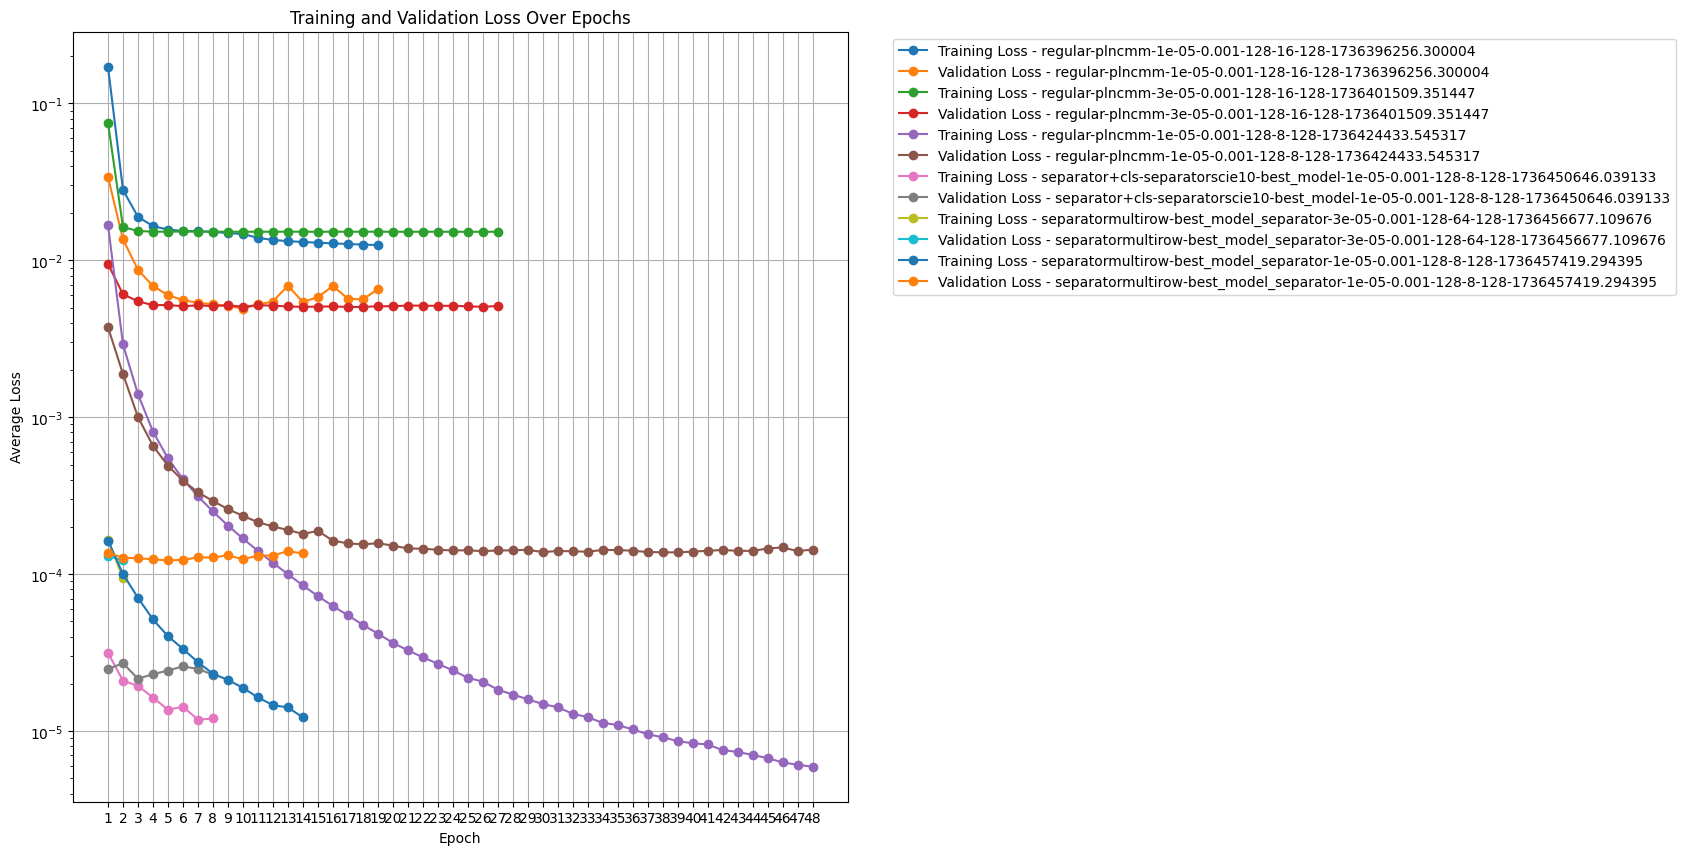

In [30]:
import matplotlib.pyplot as plt

# Load the CSV file containing the loss values
loss_df = pd.read_csv('training_loss_log.csv')

# Plot the loss values
plt.figure(figsize=(10, 10))
plt.yscale('log')
for test_name in loss_df['test_name'].unique():
    test_data = loss_df[loss_df['test_name'] == test_name]
    plt.plot(test_data['epoch'], test_data['avg_train_loss'], marker='o', linestyle='-', label=f'Training Loss - {test_name}')
    plt.plot(test_data['epoch'], test_data['avg_eval_loss'], marker='o', linestyle='-', label=f'Validation Loss - {test_name}')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks(range(1, loss_df['epoch'].max() + 1))
plt.title('Training and Validation Loss Over Epochs')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

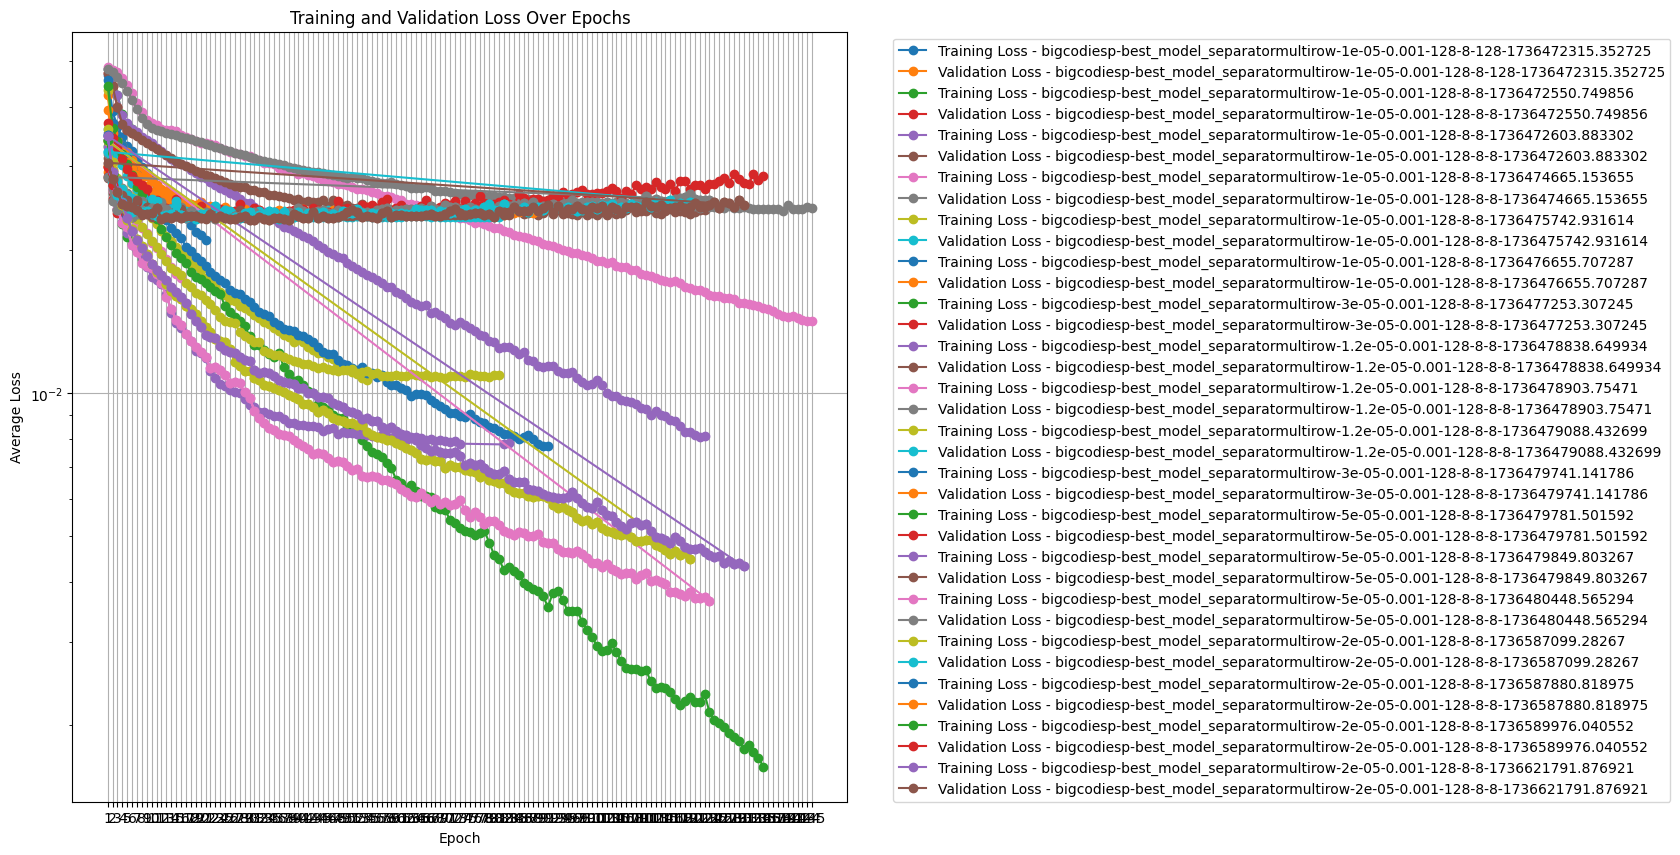

In [32]:
import matplotlib.pyplot as plt

# Load the CSV file containing the loss values
loss_df = pd.read_csv('bigcodiesp_loss_log.csv')

# Plot the loss values
plt.figure(figsize=(10, 10))
plt.yscale('log')
for test_name in loss_df['test_name'].unique():
    test_data = loss_df[loss_df['test_name'] == test_name]
    plt.plot(test_data['epoch'], test_data['avg_train_loss'], marker='o', linestyle='-', label=f'Training Loss - {test_name}')
    plt.plot(test_data['epoch'], test_data['avg_eval_loss'], marker='o', linestyle='-', label=f'Validation Loss - {test_name}')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks(range(1, loss_df['epoch'].max() + 1))
plt.title('Training and Validation Loss Over Epochs')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Test model with custom text

In [57]:
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np

# Load the original data to initialize MLBinarizer
df = pd.read_csv('/home/david/workspace/CIE-10/csv_import_scripts/cie10-es-diagnoses.csv')
icd10_codes = df['code'].apply(lambda x: [x.strip().upper().split(".")[0]]).tolist()
mlb = MultiLabelBinarizer()
mlb.fit(icd10_codes)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("plncmm/bert-clinical-scratch-wl-es", do_lower_case=True)
model = BertForSequenceClassification.from_pretrained("best_model_bigcodiesp", num_labels=len(mlb.classes_))

def predict_icd10(text, model, tokenizer, device, mlb, max_length=128, threshold=0.0001):
    model.to(device)  # Move the model to the GPU
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Tokenize the input text
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Make the prediction
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.sigmoid(logits).cpu().numpy()

        # Get indices of predictions above threshold
        prediction_indices = np.where(probabilities[0] > threshold)[0]

        # Get the actual ICD-10 codes and their probabilities
        predictions = []
        for idx in prediction_indices:
            code = mlb.classes_[idx]
            prob = probabilities[0][idx]
            predictions.append((code, prob))

        # Sort by probability
        predictions.sort(key=lambda x: x[1], reverse=True)

        # Return both the codes and their probabilities
        return predictions

# Load the best model

text = "Presentamos el caso de un paciente varón de 66 años con antecedentes de hiperglucemia en tratamiento dietético, dudosa tuberculosis (TBC) epididimaria, decorticación de cuerdas vocales y fumador de 40 cigarrillos/día, que acudió a consultas externas por presentar episodio de hematuria. Exploración física: buen estado general. Tacto rectal: próstata grado I-II/IV, consistencia elástica, límites conservados. No se aprecian áreas sospechosas. Se realizan análisis de sangre (hemograma: hematíes 5,09 millones/mm; hemoglobina 15,8 gr/dl; hematocrito 47,35%; plaquetas 250,0 miles/mm; leucocitos 10,67 miles/mm (neutrófilos 47,10%, linfocitos 44,9%, eosinófilos 1,20%, basófilos 0,8%). Estudio de coagulación: sin alteraciones. Bioquímica: sin alteraciones; PSA 2,9) y orina (Sistemático de orina: densidad 1015; pH 6,5; leucocitos 500/microl; nitritos negativos; eritrocitos 10/campo. Sedimento: leucocitos abundantes), con citologías de orina negativas (intenso componente inflamatorio agudo), radiografía simple de abdomen en la que se objetiva litiasis en polo inferior de riñón izquierdo y ecografía abdominal con riñón derecho normal, litiasis en polo inferior de riñón izquierdo y dilatación irregular del uréter de ese mismo lado. A nivel vesical se aprecia masa de aproximadamente 1 cm de diámetro máximo sobre cara lateral izquierda. Se realiza UIV en la que se observa un riñón izquierdo con dilatación calicial e irregularidades en todo su contorno, dilatación del uréter del mismo lado, de contornos tortuosos e irregulares, hasta uréter iliaco. En sus últimos 8-10 cm hasta vejiga, dicho uréter presenta apariencia normal. Cistograma con irregularidades de contorno en su porción superior. Se lleva a cabo cistoscopia apreciándose en cara lateral izquierda de vejiga una tumoración, de aspecto sólido y coloración blanquecina, que impide la visión del orificio ureteral izquierdo. Se solicita cultivo de orina en Löwenstein, y se lleva a cabo RTU de masa vesical. El postoperatorio cursa sin incidencias. Informe de AP: cistitis granulomatosa tuberculoide, compatible con TBC. Lowenstein en orina: Positivo para Mycobacterium tuberculosis. Se diagnostica de tuberculosis genitourinaria con tuberculoma vesical y afectación renoureteral izquierda y comienza tratamiento tuberculostático (Isoniacida 5 mg/kg/día + Pirazinamida 30 mg/kg/día + Rifampicina 10 mg/kg/día durante 2 meses. Isoniacida + Rifampicina en las mismas dosis durante los 4 meses siguientes). A lo largo de su seguimiento (14 meses después de realizado el diagnóstico y habiendo finalizado el tratamiento) presentó fístula con exudado en teste izquierdo en cuya tinción no se observaron BAAR, con Lowenstein negativos. Cerró con curas locales. Se realizó ecografía testicular de control observándose cambios crónicos en ambos epidídimos con pequeño hidrocele bilateral. Se llevan a cabo UIV de control presentando buena evolución, mejorando la función y la morfología de la vía urinaria (izquierda). En la última realizada (4 años después del diagnóstico) se aprecia alteración en la morfología del polo inferior del riñón izquierdo con disminución de la cortical y calcificación abigarrada asociada en el parénquima, todo ello en relación con su diagnóstico de TBC. Uréteres de calibre y morfología normal. Vejiga de esfuerzo e hipertrofia prostática. Se mantuvieron cultivos de orina en Löwenstein negativos finalizado el tratamiento médico."
predictions = predict_icd10(text, model, tokenizer, device, mlb)
print("\nPredicted ICD-10 codes and probabilities:")
for code, prob in predictions:
    icd10_text = df[df['code'].str.startswith(code)].iloc[0]["description"]

    print(f"Probability: {prob:.8f}, Code: {code}, Text: {icd10_text}")


Predicted ICD-10 codes and probabilities:
Probability: 0.62017411, Code: R31, Text: Hematuria
Probability: 0.50306952, Code: R52, Text: Dolor, no especificado | Dolor agudo NEOM | Dolor generalizado NEOM | Dolor NEOM
Probability: 0.41110882, Code: R69, Text: Enfermedad NEOM | - Casos de enfermedad desconocidos o sin especificar
Probability: 0.39899826, Code: R59, Text: Adenomegalia
Probability: 0.36649144, Code: A18, Text: Tuberculosis de otros órganos
Probability: 0.36203852, Code: N50, Text: Otros trastornos de los órganos genitales masculinos y los no especificados
Probability: 0.35884380, Code: E11, Text: Diabetes mellitus tipo 2
Probability: 0.33788246, Code: R60, Text: Edema, no clasificado bajo otro concepto
Probability: 0.30816075, Code: N28, Text: Otros trastornos del riñón y del uréter, no clasificados bajo otro concepto
Probability: 0.29782677, Code: N32, Text: Otros trastornos de vejiga
Probability: 0.28200734, Code: I10, Text: Hipertensión esencial (primaria)
Probability:

KeyboardInterrupt: 

sharp minima

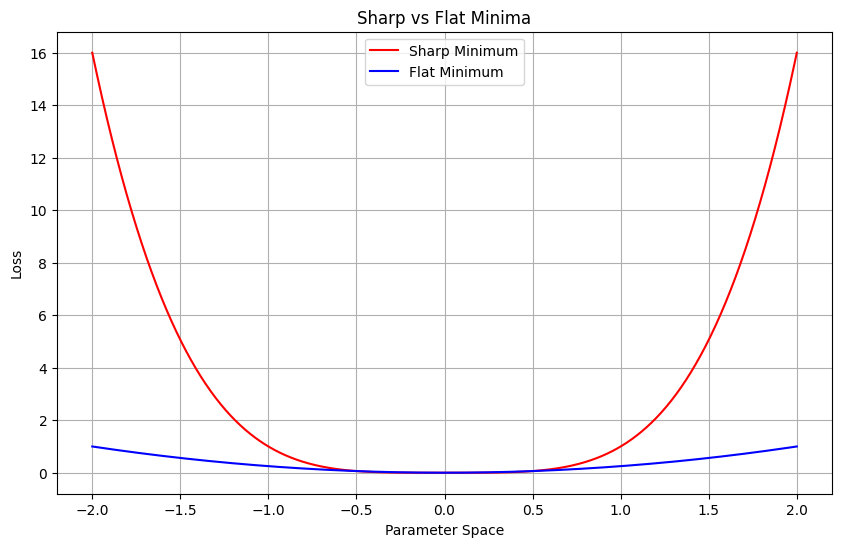

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_minima_comparison():
    # Generate x values
    x = np.linspace(-2, 2, 1000)

    # Sharp minimum
    sharp = x**4

    # Flat minimum
    flat = 0.25 * x**2

    plt.figure(figsize=(10, 6))
    plt.plot(x, sharp, label='Sharp Minimum', color='red')
    plt.plot(x, flat, label='Flat Minimum', color='blue')
    plt.title('Sharp vs Flat Minima')
    plt.xlabel('Parameter Space')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_minima_comparison()

Scheduler learning rate

# Learning Rate Scheduler with Warmup: Step-by-Step Plan

1. Define warmup period
2. Implement linear increase during warmup
3. Implement linear decay after warmup
4. Monitor learning rate changes

## Key Components:

1. **Warmup Phase**:
   - Starts with very small learning rate
   - Linearly increases to initial_lr
   - Prevents early training instability

2. **Decay Phase**:
   - Linearly decreases from initial_lr
   - Helps fine-tune at end of training
   - Prevents overshooting optimal parameters

3. **Parameters**:
   - num_warmup_steps: Length of warmup period
   - num_training_steps: Total training steps
   - initial_lr: Starting learning rate after warmup


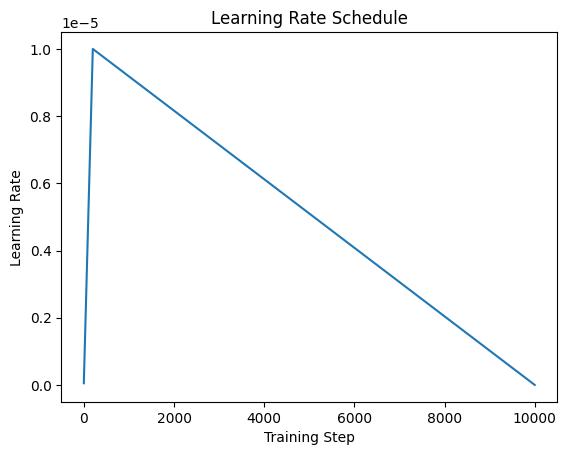

In [23]:
import matplotlib.pyplot as plt

lrs = []
epochs = 100
total_batches = 100
percent_warmup = 2
num_training_steps = epochs * total_batches
num_warmup_steps = num_training_steps / 100 * percent_warmup
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

for step in range(num_training_steps):
    scheduler.step()
    lrs.append(scheduler.get_last_lr()[0])

plt.plot(lrs)
plt.title('Learning Rate Schedule')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.show()


